# Scube tutorial: Alignment of consecutive ST slices on mouse embryo Stereo-seq dataset

July 2023

Dataset: 13 ST slices of mouse embryos ([here](https://zenodo.org/record/8167488))

In [1]:
import SPACEL
from SPACEL import Scube
import scanpy as sc
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Spatial transcriptomic data import

The input data type of Scube is a list of anndata objects for each slice. The anndata objects of each slice must contain a column of spatial domain for alignment in ``.obs``.

In [2]:
adata = sc.read(f'../data/stereo_seq_mouse_embryo/mouse_embryo_all_slices.h5ad')
adata_list=[]
for i in range(13):
    adata_list.append(adata[adata.obs.slice==i+1])
    adata_list[i].obs.spatial_domain = adata_list[i].obs.spatial_domain.astype('category')

## Pairwise alignment

Here, we perform pairwise alignment of slices. The ``cluster_key`` is a column of ``.obs`` which contain spatial domain information used for alignment. The ``n_neighbors`` affect how much neighbors are considered when calculate similarity of two slices. The ``knn_exclude_cutoff`` affect max distance of neighbors. By default, ``n_neighbors = 15`` and ``knn_exclude_cutoff = n_neighbors`` means a spot/cell in source slices consider 15 neighbors in target slices, and neighbor will be exclude when the distance of neighbors larger than the median of neareast 30 neighbors distance in all spot/cell in target slice. ``p`` affect the exponent of overlap penalty, and a larger p means stronger partial alignment capability.

In [3]:
Scube.align(adata_list,
      cluster_key='spatial_domain', 
      n_neighbors = 15, 
      n_threads=10,
      p=1,
      write_loc_path='Scube_outputs/aligned_coordinates.csv'
    )
adata = sc.concat(adata_list)
adata.write(f'../data/stereo_seq_mouse_embryo/mouse_embryo_all_slices.h5ad')

Start alignment...
Alignment slice 1 to 0
Alignment slice 2 to 1
Alignment slice 3 to 2
Alignment slice 4 to 3
Alignment slice 5 to 4
Alignment slice 6 to 5
Alignment slice 7 to 6
Alignment slice 8 to 7
Alignment slice 9 to 8
Alignment slice 10 to 9
Alignment slice 11 to 10
Alignment slice 12 to 11
Runtime: 1901.174468755722 s


After alignment, the new spots/cells location coordinates saved in ``.obsm['spatial_aligned']`` of anndata object of each slices. When ``write_loc_path`` provied by users, the location coordinates of all spots/cells of all slices will be saved in ``write_loc_path``.

## Plot alignment results

Plot all aligned slices stacked in a single figure. Spots are colored based on the annotations.

In [4]:
color_anno = ['#bd6f37', '#e3c8ab', '#994d20', '#823f22', '#3a4d9d', '#455ea9','#6989c8', '#683784', '#c1b846', '#80b7bf', '#7ba22f', '#915998', '#7bb3cd', '#933780', '#68468f', '#d5d1d6', '#97922c', '#67a98c','#81163c', '#ba4343', '#c76b6f', '#962247', '#751932', '#5c9a42', '#324557', '#182a14', '#7e2a7a', '#67832d', '#494184', '#769f34']
anno = ['Brain', 'Spinal cord', 'Sympathetic nerve', 'Dorsal root ganglion', 'Epidermis', 'Mucosal epithelium', 'Olfactory epithelium', 'Choroid plexus', 'Meninges', 'Inner ear', 'Eye', 'Jaw and tooth', 'Kidney', 'Adrenal gland', 'Thymus', 'Cavity', 'Blood vessel', 'Connective tissue', 'Adipose tissue','Smooth muscle', 'Testis', 'Heart', 'Muscle','Cartilage primordium', 'Cartilage', 'Bone', 'Liver', 'Pancreas','GI tract', 'Lung']

In [5]:
import numpy as np
import pandas as pd
dic = dict(zip(anno, color_anno))
adata = adata[adata.obs.annotation != 'Cavity']
adata.uns['annotation_colors'] = np.array(pd.Series(np.unique(adata.obs['annotation'])).replace(dic))
adata.obsm['spatial_aligned'] = np.array(adata.obsm['spatial_aligned'])

(-315.0, 315.0)

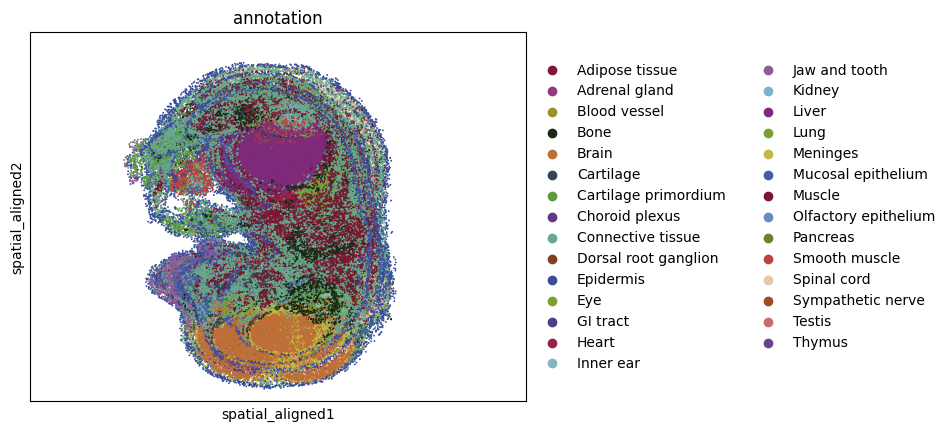

In [6]:
sc.pl.embedding(adata,basis='spatial_aligned',color='annotation',s=7,show=False)
plt.xlim(-315,315)
plt.ylim(-315,315)